##Раздел 1 - знакомство с данными

In [51]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import f

plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True

In [52]:
#Подгружаем данные
df = pd.read_excel("data_macro.xlsx").T
df.columns = df.iloc[0]
df = df[1:]
df = df.rename(columns={'index': 'Year'})
for col in df.columns:
    df[col] = df[col].astype(float)
df.head()

Unnamed: 0,SNOB_t,SNOB_t-1,Output_Gap_t,Dummy_Crisis,Fiscal_Rule_t-1,CB_bank_key_t-1,GDP_growth_EU_t
2001,4.000000,4.000000,0.689,0.0,4.000000,6.44,2.161357
2002,4.934853,4.000000,-0.390,0.0,4.000000,6.88,1.097914
2003,5.533662,4.934853,-1.707,0.0,4.032841,6.63,0.937146
2004,4.639053,5.533662,0.106,0.0,2.882840,3.56,2.600215
2005,4.212598,4.639053,0.823,0.0,3.326772,1.75,1.983823


In [53]:
round(df.describe(include='all'),3)

Unnamed: 0,SNOB_t,SNOB_t-1,Output_Gap_t,Dummy_Crisis,Fiscal_Rule_t-1,CB_bank_key_t-1,GDP_growth_EU_t
count,25.000,25.000,25.000,25.000,25.000,25.000,25.000
mean,3.300,3.352,-0.010,0.320,3.215,2.564,1.384
std,0.825,0.827,1.278,0.476,0.513,2.063,2.362
min,2.410,2.410,-2.612,0.000,2.366,0.060,-5.573
25%,2.706,2.714,-0.612,0.000,2.883,1.310,0.937
50%,3.013,3.031,0.098,0.000,3.137,1.750,1.946
75%,3.697,3.824,0.689,1.000,3.534,3.880,2.370
max,5.534,5.534,2.828,1.000,4.033,6.880,6.357


##Раздел 2 - строим модель

In [54]:
#Построим модель с дамми-переменной
y1 = df["SNOB_t"]
X1 = sm.add_constant(df[["SNOB_t-1","CB_bank_key_t-1","Output_Gap_t","Dummy_Crisis",
                         "Fiscal_Rule_t-1","GDP_growth_EU_t"]])

model = sm.OLS(y1, X1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 SNOB_t   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     27.03
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           4.51e-08
Time:                        19:09:43   Log-Likelihood:                -1.3562
No. Observations:                  25   AIC:                             16.71
Df Residuals:                      18   BIC:                             25.24
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.3787      0.515     

Уберем переменную $Dummy\ Crisis$, незначимую на уровне $8\%$

In [55]:
y2 = df["SNOB_t"]
X2 = sm.add_constant(df[["SNOB_t-1","CB_bank_key_t-1","Output_Gap_t",
                         "Fiscal_Rule_t-1","GDP_growth_EU_t"]])

model = sm.OLS(y2, X2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 SNOB_t   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     32.82
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           1.03e-08
Time:                        19:09:43   Log-Likelihood:                -1.8321
No. Observations:                  25   AIC:                             15.66
Df Residuals:                      19   BIC:                             22.98
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.2006      0.465     

Теперь проверим устойчивость путем теста Чоу

In [56]:
X1_ch = X2[:17]
y1_ch = y2[:17]

X2_ch = sm.add_constant(X2[17:])
y2_ch = y2[17:]

model1 = sm.OLS(y1_ch, X1_ch).fit()
model2 = sm.OLS(y2_ch, X2_ch).fit()

RSS1 = sum(model1.resid**2)
RSS2 = sum(model2.resid**2)
RSS = sum(model.resid**2)

k = X1_ch.shape[1]
n1 = len(y1_ch)
n2 = len(y2_ch)

F = ((RSS - (RSS1 + RSS2)) / k) / ((RSS1 + RSS2) / (n1 + n2 - 2*k))
p_value = 1 - f.cdf(F, dfn=k, dfd=(n1 + n2 - 2*k))
F_crit = f.ppf(1 - 0.08, k, n1 + n2 - 2*k)

print("F-статистика Чоу:", F)
print("p-value:", p_value)
print("Критическое F:", F_crit)

F-статистика Чоу: 2.371906083009972
p-value: 0.09040760209857668
Критическое F: 2.481070190038662


Полученная F-статистика (Чоу) ниже критической, а также p-value больше 8%. Можно сделать вывод, что гипотеза о том, что коэффициенты регрессии не различаются между двумя группами, не отвергаются.
Значит, модель устойчива между группами на значимости в 8%, т.е. коэффициенты регрессии статистически не различаются между годами с таргетным процентом 3 и 4

Ура, все осталось устойчивым!

##Раздел 3 - визуализация

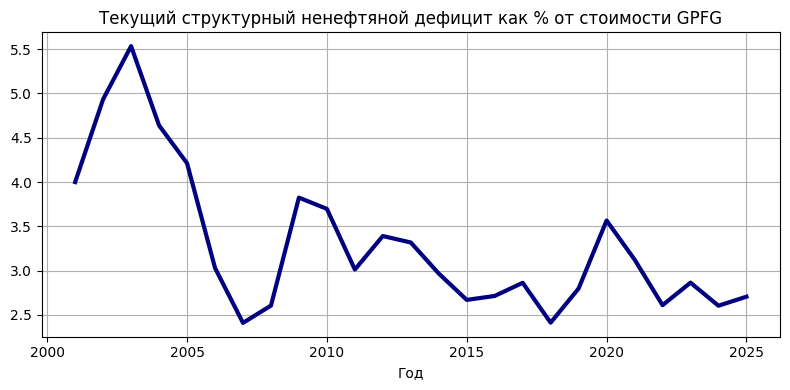

In [ ]:
plt.plot(df["SNOB_t"], color="navy", linewidth=3)
plt.title("Текущий структурный ненефтяной дефицит как % от стоимости GPFG")
plt.xlabel("Год")

plt.tight_layout()
plt.show()

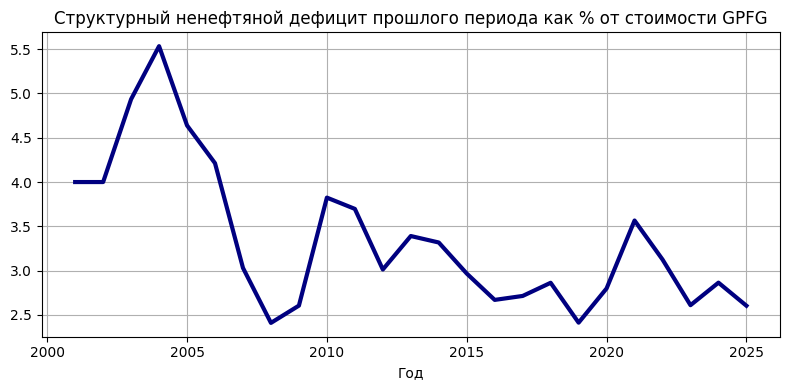

In [ ]:
plt.plot(df["SNOB_t-1"], color="navy", linewidth=3)
plt.title("Структурный ненефтяной дефицит прошлого периода как % от стоимости GPFG")
plt.xlabel("Год")

plt.tight_layout()
plt.show()

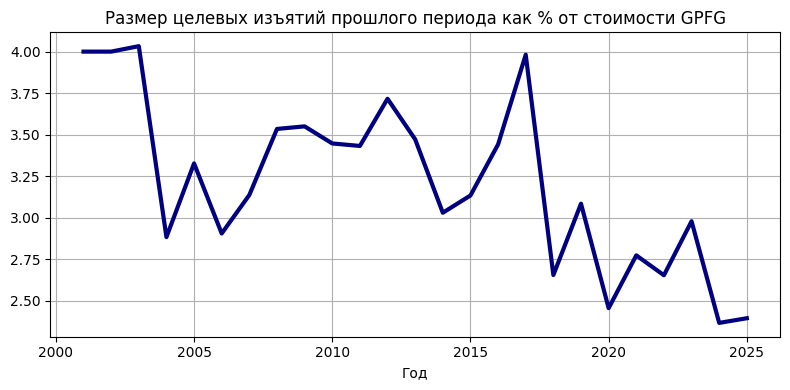

In [ ]:
plt.plot(df["Fiscal_Rule_t-1"], color="navy", linewidth=3)
plt.title("Размер целевых изъятий прошлого периода как % от стоимости GPFG")
plt.xlabel("Год")

plt.tight_layout()
plt.show()

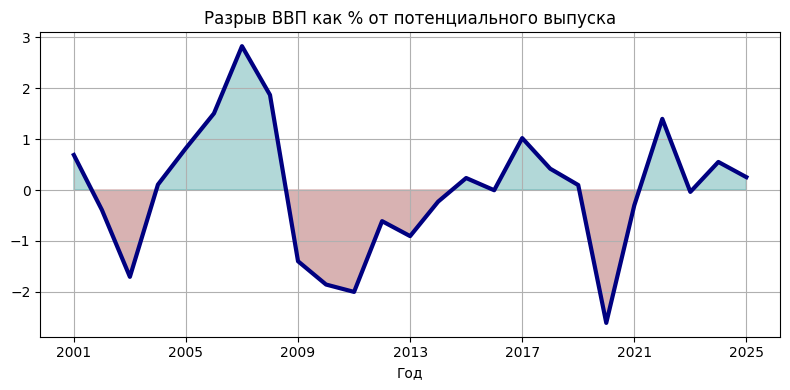

In [ ]:
y_ = pd.to_numeric(df["Output_Gap_t"])

plt.plot(y_.values, color="navy", linewidth=3)

plt.fill_between(range(len(y_)), y_.values, 0,
                 where=(y_.values >= 0), color='teal',
                 interpolate=True, alpha=0.3)
plt.fill_between(range(len(y_)), y_.values, 0,
                 where=(y_.values < 0), color='maroon',
                 interpolate=True, alpha=0.3)

plt.title("Разрыв ВВП как % от потенциального выпуска")
plt.xlabel("Год")
plt.xticks(range(len(y_))[::4], df.index[::4])

plt.tight_layout()
plt.show()

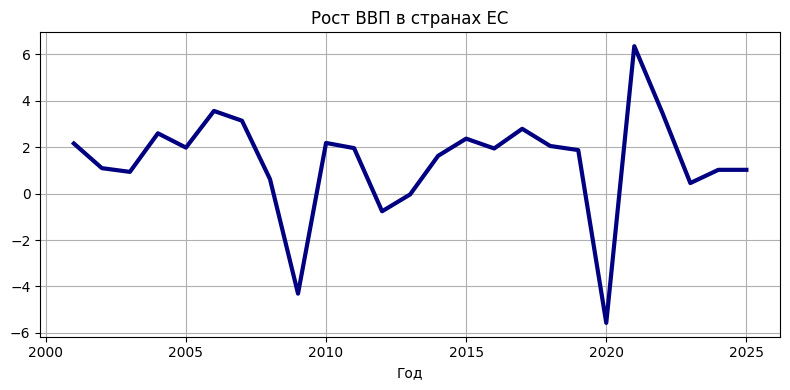

In [ ]:
plt.plot(df["GDP_growth_EU_t"], color="navy", linewidth=3)
plt.title("Рост ВВП в странах ЕС")
plt.xlabel("Год")

plt.tight_layout()
plt.show()

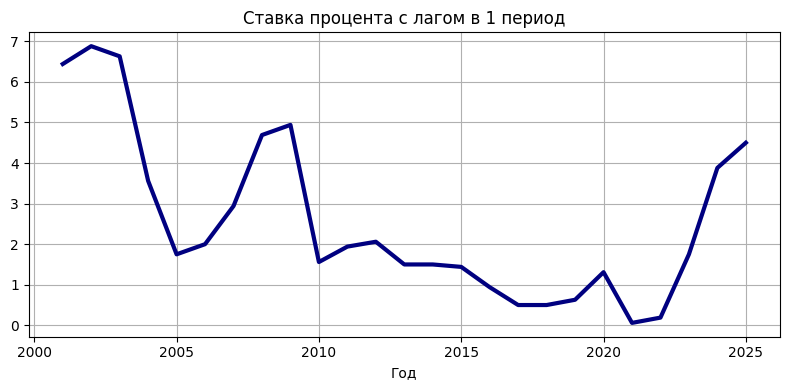

In [ ]:
plt.plot(df["CB_bank_key_t-1"], color="navy", linewidth=3)
plt.title("Ставка процента с лагом в 1 период")
plt.xlabel("Год")

plt.tight_layout()
plt.show()

Обозначим "Структурный ненефтяной баланс (дефицит)" как СНБ (д).

Также рассчитаем прогноз на следующие 2 периода на основе средних значений за последние 5 лет. При этом переменная $Fund\ value_{t-1}$

In [ ]:
df_future = pd.DataFrame({"Year": [2026, 2027]})
df_future["SNOB_t-1"] = None
df_future["CB_bank_key_t-1"] = df["CB_bank_key_t-1"].tail(5).mean()
df_future["Output_Gap_t"] = df["Output_Gap_t"].tail(5).mean()
df_future["GDP_growth_EU_t"] = df["GDP_growth_EU_t"].tail(5).mean()
df_future["Fiscal_Rule_t-1"] = df["Fiscal_Rule_t-1"].iloc[-1]

last_snob = df["SNOB_t"].iloc[-1]
predictions = []

for i in range(len(df_future)):
    df_future.at[i, "SNOB_t-1"] = last_snob

    X_new = pd.DataFrame([{
        "const": 1,
        "SNOB_t-1": df_future.at[i, "SNOB_t-1"],
        "CB_bank_key_t-1": df_future.at[i, "CB_bank_key_t-1"],
        "Output_Gap_t": df_future.at[i, "Output_Gap_t"],
        "GDP_growth_EU_t": df_future.at[i, "GDP_growth_EU_t"],
        "Fiscal_Rule_t-1": df_future.at[i, "Fiscal_Rule_t-1"]
    }])

    pred = model.predict(X_new)[0]
    predictions.append(pred)
    last_snob = pred

df_future["SNOB_t"] = predictions
df_future.set_index("Year", inplace=True)

df_all = pd.concat([df, df_future])

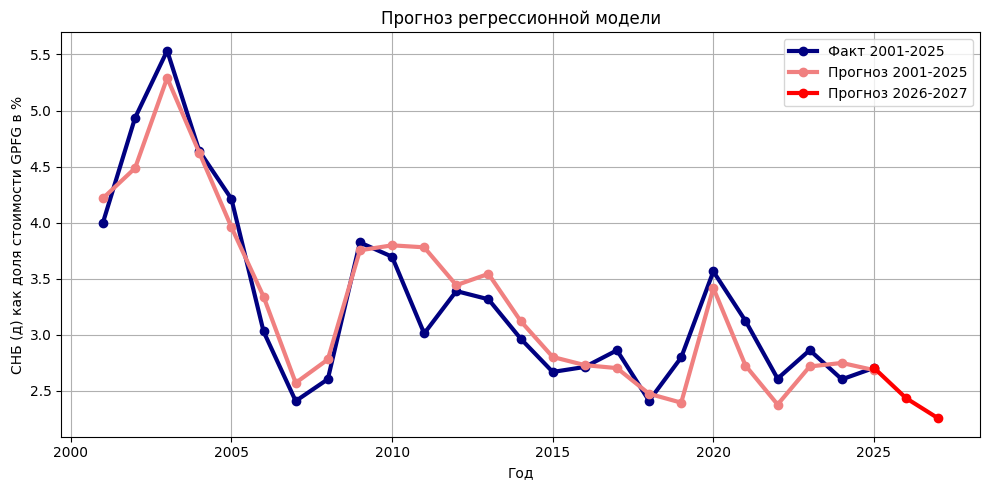

In [ ]:
df['SNOB_pred'] = sm.OLS(y2, X2).fit().predict(X2)

plt.figure(figsize=(10,5))
plt.plot(df["SNOB_t"], label="Факт 2001-2025", marker='o', color='navy', linewidth=3)
plt.plot(df["SNOB_pred"], label="Прогноз 2001-2025", marker='o', color='lightcoral', linewidth=3)
plt.plot(df_all["SNOB_t"][-3:], label="Прогноз 2026-2027", marker='o', color='red', linewidth=3)
plt.title("Прогноз регрессионной модели")
plt.xlabel("Год")
plt.ylabel("СНБ (д) как доля стоимости GPFG в %")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()